In [1]:
import pandas as pd
import os
import random
import numpy as np
from tensorflow.keras.models import *
from keras import callbacks
from tensorflow.keras.layers import *
from keras.layers import *
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pickle
import torch
import torchvision
from torchvision import models
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from sklearn.preprocessing import LabelEncoder
import torch.nn.functional as F
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import seaborn as sns

In [2]:
def fill_between_values(col, df, col_name):
    first_one_index = col[col == 1].index.min()
    # 如果存在1的值，将其之前的所有值填充为0.5
    if first_one_index is not None:
        df.loc[:first_one_index - 1, col_name] = 0.5

    start_index = None
    previous_value = None
    for idx, value in col.items():
        if value == 1 or value == 0.5:
            if start_index is not None:
                if previous_value == 1:
                    df.loc[start_index:idx-1, col_name] = 1
                elif previous_value == 0.5:
                    df.loc[start_index:idx-1, col_name] = 0.5
                start_index = None
            previous_value = value
        elif start_index is None:
            start_index = idx

    return df[col_name]

def count_directories(path):
    dir_count = 0
    for root, dirs, files in os.walk(path):
        dir_count += len(dirs)
        break 
    return dir_count

In [3]:
df = pd.read_csv('1026_clean.csv', header=None, names=["date", "time", "sensor", "status"])
df = df.iloc[::-1].reset_index(drop=True)

print(type(df))
print(df[:10])

df = df[df['sensor'] != 'sensor']
df['sensor'] = pd.to_numeric(df['sensor'])
df['status'] = df['status'].astype(float)

special_sensors = [100,101,102,103,104,105,106]
for sensor in special_sensors:
    df[sensor] = (df["sensor"] == sensor).astype(int) * df["status"]

for col_name in df.columns[4:]:
    df[col_name] = fill_between_values(df[col_name], df, col_name)
print(df[:10])

for sensor in special_sensors:
    df = df[df["sensor"] != sensor]

print(df[:10])

df['label'] = df[special_sensors].apply(tuple, axis=1)

print(df[:10])

df = df[df['sensor'] != 'sensor']
df['sensor'] = pd.to_numeric(df['sensor'])
sensor_column = df['sensor'].astype(float)
status_column = df['status'].astype(float)

status_column[status_column == 1] = 0
status_column[status_column == 0.5] = -0.1

df['sensor'] = status_column + sensor_column

print(df[:10])

<class 'pandas.core.frame.DataFrame'>
         date      time sensor status
0  2023/10/26  14:34:05      1      1
1  2023/10/26  14:34:08    100      1
2  2023/10/26  14:34:11      2      1
3  2023/10/26  14:34:12      3      1
4  2023/10/26  14:34:14      1    0.5
5  2023/10/26  14:34:16    102      1
6  2023/10/26  14:34:17      3    0.5
7  2023/10/26  14:34:18      2    0.5
8  2023/10/26  14:34:19    101      1
9  2023/10/26  14:34:20     12      1
         date      time  sensor  status  100  101  102  103  104  105  106
0  2023/10/26  14:34:05       1     1.0  0.5  0.5  0.5  0.5  0.5  0.5  0.5
1  2023/10/26  14:34:08     100     1.0  1.0  0.5  0.5  0.5  0.5  0.5  0.5
2  2023/10/26  14:34:11       2     1.0  1.0  0.5  0.5  0.5  0.5  0.5  0.5
3  2023/10/26  14:34:12       3     1.0  1.0  0.5  0.5  0.5  0.5  0.5  0.5
4  2023/10/26  14:34:14       1     0.5  1.0  0.5  0.5  0.5  0.5  0.5  0.5
5  2023/10/26  14:34:16     102     1.0  1.0  0.5  1.0  0.5  0.5  0.5  0.5
6  2023/10/26  14:3

In [4]:
columns = df.columns
window_size = 8
step_size = 1

zero_count = window_size - 1
zeros_df = pd.DataFrame(0, index=range(zero_count), columns=columns)
new_df = pd.concat([zeros_df, df], ignore_index=True)
# print(new_df[:20])

sensor_columns = new_df.columns[2]  
label_column = new_df.columns[-1]  

sensor_data = []
label_data = []

for start in range(0, new_df.shape[0] - window_size + 1, step_size):
    window_data = new_df.iloc[start:start + window_size][sensor_columns].values
    sensor_data.append(window_data)
    label_data.append(new_df.iloc[start + 7][label_column])

padded_windows  = np.array(sensor_data)
label_data  = np.array(label_data)
Y_windowed = label_data.astype(int)
for i in range (len(padded_windows)):
    padded_windows[i] = padded_windows[i][::-1]

image_data = []
labels = []

for i in range(len(padded_windows)):
    
    label = Y_windowed[i]
#    label = label.astype(str)
    label = np.array2string(label, precision=2, separator=',', suppress_small=True)
    labels.append(label)
    
label_encoder = LabelEncoder()
int_labels = label_encoder.fit_transform(labels)
mapping = dict(zip(range(len(label_encoder.classes_)), label_encoder.classes_))
print(mapping)

          date      time  sensor  status  100  101  102  103  104  105  106  \
0            0         0     0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1            0         0     0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2            0         0     0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3            0         0     0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4            0         0     0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
5            0         0     0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
6            0         0     0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
7   2023/10/26  14:34:05     1.0     1.0  0.5  0.5  0.5  0.5  0.5  0.5  0.5   
8   2023/10/26  14:34:11     2.0     1.0  1.0  0.5  0.5  0.5  0.5  0.5  0.5   
9   2023/10/26  14:34:12     3.0     1.0  1.0  0.5  0.5  0.5  0.5  0.5  0.5   
10  2023/10/26  14:34:14     0.9     0.5  1.0  0.5  0.5  0.5  0.5  0.5  0.5   
11  2023/10/26  14:34:17     2.9     0.5  1.0  0.5  

In [7]:
for i in range(len(padded_windows)):
    lights = []
    org_label = Y_windowed[i-1]
    
    for k in range (7):
        if org_label[k] == 1:
            lights.append(k)
    
    label = int_labels[i]
    label = np.array2string(label, precision=2, separator=',', suppress_small=True)
    
    label_dir = f"data/{label}"
    zero = np.zeros((110,110))
        
    for j in range(8):
        index = 109 - padded_windows[i][j]
        if index != 0:
            if index - index.astype(int) != 0:
                index = index.astype(int)
                zero[index][2*j:(2*j+1)] = 0.5
            elif index - index.astype(int) == 0:
                index = index.astype(int)
                zero[index][2*j:(2*j+1)] = 1
            else:
                zero[index][2*j:(2*j+1)] = 0

    for row in range(110):
        cols_with_value = [col for col in range(110) if zero[row][col] > 0]

        if len(cols_with_value) > 0:
            if zero[row][cols_with_value[0]] == 0.5:
                zero[row][0:cols_with_value[0]] = 1

            for k in range(0, len(cols_with_value) - 1):
                if zero[row][cols_with_value[k]] == 1 and zero[row][cols_with_value[k + 1]] == 0.5:
                    zero[row][cols_with_value[k]:cols_with_value[k + 1]] = 1

            if zero[row][cols_with_value[-1]] == 1:
                zero[row][cols_with_value[-1]:2*window_size-1] = 1

    for row in range(110):
        cols_with_value = [col for col in range(110) if zero[row][col] == 1]

        zero[row, :] = 0
        for col in cols_with_value:
            zero[row, col] = 1

    data = zero * 255
    data = data.astype('uint8')
    if not os.path.exists(label_dir):
        os.makedirs(label_dir)
    
    img_path = os.path.join(label_dir, f"{i}.png")
    img = Image.fromarray(data)
    img.save(img_path)
    
    zero = np.zeros((110, 110))

label_encoder = LabelEncoder()
int_labels = label_encoder.fit_transform(labels)
mapping = dict(zip(range(len(label_encoder.classes_)), label_encoder.classes_))
print(mapping)
with open('mapping_label.pkl', 'wb') as f:
    pickle.dump(mapping, f)

{0: '[0,0,0,0,0,0,0]', 1: '[0,0,0,0,0,0,1]', 2: '[0,0,0,0,0,1,0]', 3: '[0,0,0,0,1,0,0]', 4: '[0,0,0,0,1,0,1]', 5: '[0,0,0,0,1,1,0]', 6: '[0,0,0,1,0,0,0]', 7: '[0,0,0,1,0,1,0]', 8: '[0,0,0,1,1,0,0]', 9: '[0,1,0,1,0,0,0]', 10: '[0,1,1,0,0,0,0]', 11: '[0,1,1,1,0,0,0]', 12: '[1,0,0,0,0,0,0]', 13: '[1,0,0,1,0,0,0]', 14: '[1,0,1,0,0,0,0]', 15: '[1,1,1,0,0,0,0]'}


In [8]:
path, _ = label_dir.rsplit('/', 1)

number_of_directories = count_directories(path)
print(f'Number of directories: {number_of_directories}')

dataset_path = path
num_classes = number_of_directories

class_paths = []
for i in range(num_classes):
    
    class_path = os.path.join(dataset_path, "{}".format(i))
    class_files = os.listdir(class_path)
    class_paths.append((class_path, class_files))

for class_path, class_files in class_paths:
    random.shuffle(class_files)
    
train_file = open(dataset_path + "/train.txt", "w")
test_file = open(dataset_path + "/test.txt", "w")
for i, (class_path, class_files) in enumerate(class_paths):
    num_train = int(len(class_files) * 0.7)
    for j, filename in enumerate(class_files):
        if j < num_train:
            train_file.write("{} {}\n".format(os.path.join(class_path, filename), i))
        else:
            test_file.write("{} {}\n".format(os.path.join(class_path, filename), i))
train_file.close()
test_file.close()

Number of directories: 16


In [10]:
print(torch.backends.mps.is_available())
print(torch.backends.mps.is_built())

if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    print("CUDA is not available. Using CPU.")
    device = torch.device("cpu")

print(device)
net = torchvision.models.resnet18(weights='IMAGENET1K_V1')
# net = torchvision.models.densenet121(weights='IMAGENET1K_V1')
net.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
net.to(device)

True
True


ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

加载成功！
FOLD 1/5
------------------------------ 
 epoch 0
Validation Loss: 6.4187
------------------------------ 
 epoch 1
Validation Loss: 2.2957
------------------------------ 
 epoch 2
Validation Loss: 1.2686
------------------------------ 
 epoch 3
Validation Loss: 0.9708
------------------------------ 
 epoch 4
Validation Loss: 0.7009
------------------------------ 
 epoch 5
Validation Loss: 1.0699
------------------------------ 
 epoch 6
Validation Loss: 0.9896
------------------------------ 
 epoch 7
Validation Loss: 1.0684
------------------------------ 
 epoch 8
Validation Loss: 1.0592
------------------------------ 
 epoch 9
Validation Loss: 0.9818
------------------------------ 
 epoch 10
Validation Loss: 1.0871
------------------------------ 
 epoch 11
Validation Loss: 1.2501
------------------------------ 
 epoch 12
Validation Loss: 1.1545
------------------------------ 
 epoch 13
Validation Loss: 1.4412
------------------------------ 
 epoch 14
Validation Loss: 0.9812
-----

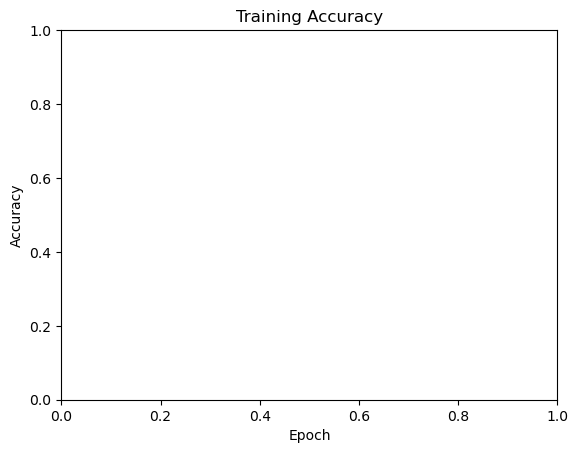

In [11]:
def MyLoader(path):
    return Image.open(path).convert('L')
    
class MyDataset (Dataset):
    def __init__(self, txt, transform=None, target_transform=None, loader=MyLoader):
        with open(txt, 'r') as fh:
            imgs = []
            for line in fh:
                line = line.strip('\n')
                line = line.rstrip()
                words = line.split( )
                imgs.append((words[0], int(words[1])))
        self.imgs = imgs
        self.transform = transform
        self.target_transform = target_transform
        self.loader = loader

    def __getitem__(self, index):
        fn, label = self.imgs[index]
        img = self.loader(fn)
        if self.transform is not None:
            img = self.transform(img)
        return img, label

    def __len__(self):
        return len(self.imgs)



root = path + '/'
train_data = MyDataset(txt=root + 'train.txt', transform=transforms.ToTensor())
test_data = MyDataset(txt=root + 'test.txt', transform=transforms.ToTensor())

test_num = len(test_data)

trainloader = DataLoader(dataset=train_data, batch_size=32, shuffle=True)
testloader = DataLoader(dataset=test_data, batch_size=32, shuffle=False)

print('加载成功！')

import torch.nn.functional as F
from sklearn.model_selection import KFold
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)


patience = 50
n_folds = 5
num_epochs = 200

kfold = KFold(n_splits=n_folds, shuffle=True)
early_stop_counter = 0
best_loss = float('inf')
best_model_wts = None

for fold, (train_ids, val_ids) in enumerate(kfold.split(trainloader.dataset)):
    print(f"FOLD {fold + 1}/{n_folds}")
    
    optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
    train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
    val_subsampler = torch.utils.data.SubsetRandomSampler(val_ids)
    
    
    trainloader_fold = torch.utils.data.DataLoader(trainloader.dataset, batch_size=32, sampler=train_subsampler)
    valloader_fold = torch.utils.data.DataLoader(trainloader.dataset, batch_size=32, sampler=val_subsampler)
    
    for epoch in range(num_epochs):
        print('-'*30, '\n','epoch', epoch)
        net.train()
        loss100 = 0.0
        correct = 0
        total = 0
        for i, data in enumerate(trainloader_fold):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels.to(device))
            loss.backward()
            optimizer.step()

            loss100 += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        net.eval()
        val_loss = 0.0
        with torch.no_grad():
            for i, data in enumerate(valloader_fold):
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = net(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        avg_val_loss = val_loss / len(valloader_fold)
        print(f"Validation Loss: {avg_val_loss:.4f}")

        if avg_val_loss < best_loss:
            best_loss = avg_val_loss
            best_model_wts = net.state_dict().copy() 
            early_stop_counter = 0
        else:
            early_stop_counter += 1

        if early_stop_counter >= patience:
            print("Early stopping!")
            break
        
model_save_path = path +'/' +'best_model.pth'
torch.save(best_model_wts, model_save_path)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.show()

Accuracy : 81.278539 %
Loss : 4.412454 %
Balanced Accuracy : 57.503765 %


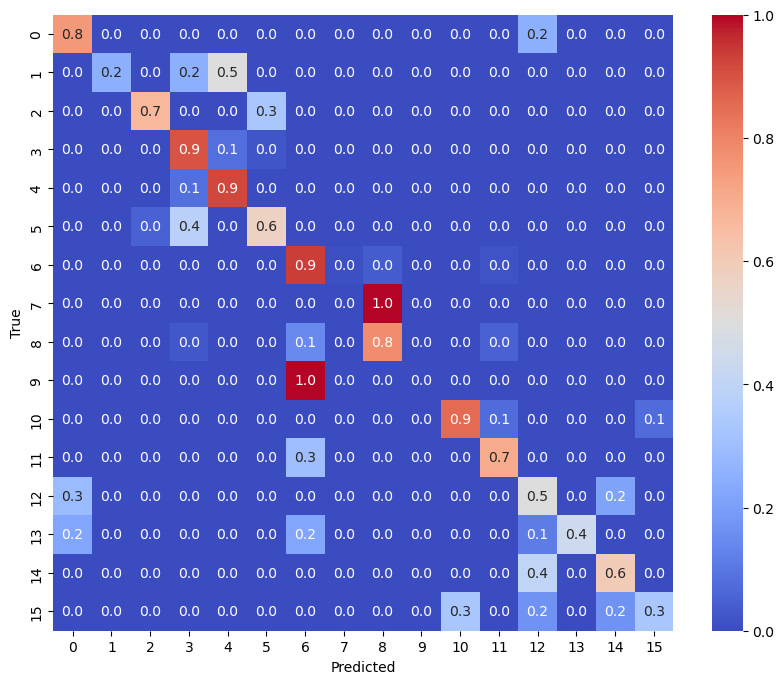

In [12]:
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import balanced_accuracy_score
predicted_list = []
labels_list = []
dataiter = iter(testloader)
correct = 0
total = 0
net.eval()
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        predicted_list.extend(predicted.cpu().numpy())
        labels_list.extend(labels.cpu().numpy())
        loss = criterion(outputs, labels)


confusion_mat = confusion_matrix(labels_list, predicted_list)
cm_normalized = confusion_mat.astype('float') / confusion_mat.sum(axis=1)[:, np.newaxis]
print('Accuracy : %f %%' % (
    100 * correct / test_num))
print('Loss : %f %%' % (
    loss.item()))
balanced_accuracy = balanced_accuracy_score(labels_list, predicted_list, adjusted=False)
print('Balanced Accuracy : %f %%' %(100 * balanced_accuracy))
#print(confusion_mat)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_normalized, annot=True, fmt='.1f', cmap='coolwarm')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.savefig('confusion_cnn.svg')
plt.show()